# CEV-model
The goal is to implement the valuation of European options in the so-called CEV
(Constant Elasticity Volatility) model, a simple extension of the Black-Scholes model specified by the dynamics.

${dS} = {\mu}{S}{dt} + {\sigma}{S}^{\beta/2}{dW} $

where μ is a parameter characterising the drift, σ is a constant parameter, the elasticity 𝛽 is a parameter between 0 and 2, and w is a standard
Brownian Motion under the risk-neutral measure.

Refer to the following papers for detailed discussion about the model
- https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1540-6261.1989.tb02414.x
- https://fincad.com/sites/default/files/wysiwyg/Resources-Wiki/cev-process-working-paper.pdf

This notebook runs through different numerical techniques for determining the valuation of European options under this model.

### Imports

In [42]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from fdm.fdm import FDM_Generic_CEV

font = {'family' : 'DejaVu Sans',
        'size'   : 16}

matplotlib.rc('font', **font)


import qf.pricing_util.option as opt
import qf.pricing_util.payoff as pf
from qf.models.blackscholes import BS
from qf.models.cev import CEV_Opt

import mc_sim.simulation as mc
from sde.gbm_process import GBM
from sde.cev_process import CEV


### 1. Determine the analytical solution 
Value a European call under the CEV dynamics as a function of the spot S<sub>0</sub>, σ, 𝛽, expiry 𝑇, and strike 𝐾 of the call.
Use the exact closed formula solution. An implementation of a displaced chi-square cumulative distribution is
necessary. Note, that the CEV model converges to the Black Scholes model as 𝛽 -> 2

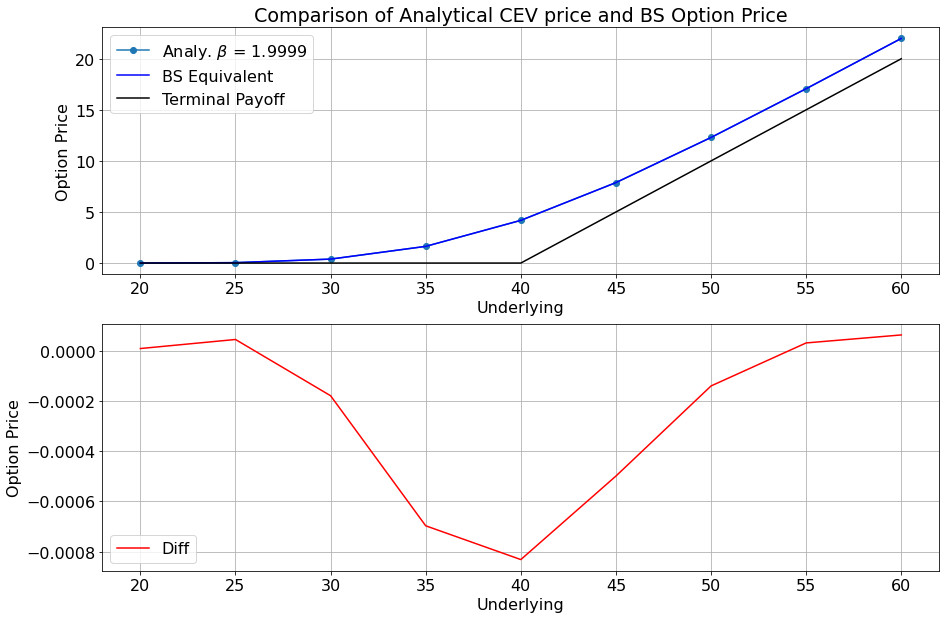

In [39]:
sig = 0.2
#choose a beta close to 2
beta = 1.9999
r = 0.05
q = 0
underlying_values = list(range(20,61,5))
K = 40.0
T = 1

prices_analy = []
prices_bs_equ = []
diff = []

payoff = []

option = opt.EuropeanOption(pf.PayOffCall(strike=K), expiry=T)

for S in underlying_values:

    #build the CEV instrument
    inst_CEV = CEV_Opt(spot=S,
                   sig=sig,
                   beta=beta,
                   r=r,
                   q=q,
                   option=option
                   )

    #build the Black Scholes instrument
    inst_BS = BS(spot=S,
                 sig=sig,
                 r=r,
                 q=q,
                 option=option
                 )
            
    prices_bs_equ.append(inst_BS.Analytical_NPV())
    prices_analy.append(inst_CEV.Analytical_NPV())
    payoff.append(inst_CEV.PayOff(S))
        
    #compare NPV
    diff.append(inst_CEV.Analytical_NPV() - inst_BS.Analytical_NPV())

fig, ax = plt.subplots(2,figsize=(15, 10))

title_ = r'Comparison of Analytical CEV price and BS Option Price'
line_handles = []

anal_label = r'Analy. $\beta$ = ' + str(beta)

line_analy, = ax[0].plot(np.array(underlying_values), np.array(prices_analy), 'o-', label=anal_label)
line_bs, = ax[0].plot(np.array(underlying_values), np.array(prices_bs_equ), 'b-', label = 'BS Equivalent')
line_payoff, = ax[0].plot(np.array(underlying_values), np.array(payoff), 'k', label = 'Terminal Payoff')

line_handles = [line_analy, line_bs, line_payoff]
ax[0].legend(handles=line_handles)
for a in ax.flat:
    a.set(xlabel='Underlying', ylabel='Option Price')
    
line_diff, = ax[1].plot(np.array(underlying_values), np.array(diff), 'r', label = 'Diff')
line_handles = [line_diff]
ax[1].legend(handles=line_handles)

ax[0].set_title(title_)
ax[0].grid()
ax[1].grid()
plt.show()

### 2. Monte Carlo Solution
Implement a solution with Monte-Carlo simulations to price the option above. The goal is to design an object-oriented framework that is extendable to other models/options. 
Comparison below shows convergence to the analytical solution. A good exercise would be to investigate the analytical approximation for varying parameters of μ,σ, 𝛽, T S and K

In [44]:

# configure the simulation parameters
config = mc.SimulationConfig(numberSimus=10000,
                             snapshotsims=1000,
                             CI=0.95,
                             goal=0.01
                             )

sig = 0.2
# choose a beta close to 2
beta = 1.999
r = 0.05
q = 0.02
S = 30.0
K = 30.0
T = 1

option = opt.EuropeanOption(pf.PayOffCall(strike=K), expiry=T)

# build the CEV instrument
test_instrument = CEV_Opt(spot=S,
                   sig=sig,
                   beta=beta,
                   r=r,
                   q=q,
                   option=option
                   )

mapping = mc.SimMapping(underlying_process=CEV(drift=test_instrument.Q_drift,
                                               vol=test_instrument.Q_vol,
                                               power=test_instrument.Power,
                                               ),
                        mkt_instrument=test_instrument
                        )

# create the simulation object
sim = mc.Simulation(simconfig=config,
                    simmapping=mapping,
                    debug=True
                    )

# run simuation and gather results
sim_status, sim_snapshot = sim.run()
est_npv = sim_snapshot[1]
std_error = sim_snapshot[2] / 2.0
upper_bound_est = est_npv + std_error
lower_bound_est = est_npv - std_error

print('Analytical_NPV')
print(test_instrument.Analytical_NPV())
print('Simulation NPV')
print(f'Lower Bound NPV = {lower_bound_est}')
print(f'Upper Bound NPV = {upper_bound_est}')

Running simulation
Simulation Number  | Simulation Output  | CI width |
           1000                 2.61       0.4109
           2000                 2.72       0.2991
           3000                 2.66       0.2416
           4000                 2.68       0.2106
           5000                 2.72       0.1892
           6000                 2.69       0.1716
           7000                 2.70       0.1588
           8000                 2.74       0.1501
           9000                 2.76       0.1423
          10000                 2.75       0.1348
Analytical_NPV
2.7620416095386027
Sim_NPV
Lower Bound NPV = 2.678826651049842
Upper Bound NPV = 2.813641224683787


### 3. Finite Difference Method Solution
Use the Crank-Nicolson method to calculate prices to the model above. Compare with the analytical solution and Black Scholes equivalent.

- convergence of solution (still to investigate)
- speed of execution (still to complete)
- margin of error to the exact analytical solution

Running for Underlying value: 20
Running for Underlying value: 22
Running for Underlying value: 24
Running for Underlying value: 26
Running for Underlying value: 28
Running for Underlying value: 30
Running for Underlying value: 32
Running for Underlying value: 34
Running for Underlying value: 36
Running for Underlying value: 38
Running for Underlying value: 40
Running for Underlying value: 42
Running for Underlying value: 44
Running for Underlying value: 46
Running for Underlying value: 48
Running for Underlying value: 50
Running for Underlying value: 52
Running for Underlying value: 54
Running for Underlying value: 56
Running for Underlying value: 58
Running for Underlying value: 60


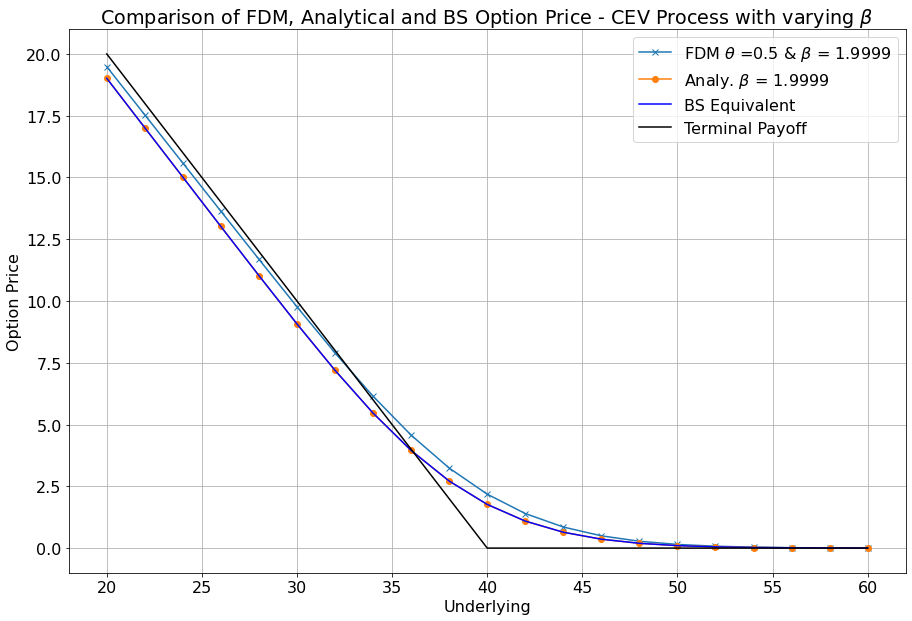

In [40]:

beta = 1.9999
K = 40.0
T = 0.5
r = 0.05
q = 0.0
sig = 0.2
theta = 0.5
N = 300
Nj = 300

underlying_values = list(range(20,61,2))
beta_values = [1.9999]#np.linspace(0.1,1.999,3).tolist()

option = opt.EuropeanOption(pf.PayOffPut(strike=K), expiry=T)

prices_fdm = {}
prices_analy = {}

for beta in beta_values:
    prices_fdm[beta] = []
    prices_analy[beta] = []

prices_bs_equ = []

payoff = []
for S in underlying_values:
    print(f"Running for Underlying value: {S}")

    for beta in beta_values:
        # build the CEV instrument
        CEV_Euro = CEV_Opt(spot=S,
                          sig=sig,
                          beta=beta,
                          r=r,
                          q=q,
                          option=option
                          )

        FDM_Generic_engine = FDM_Generic_CEV(
                        beta=(CEV_Euro.Power*2.0),
                        mkt_instrument=CEV_Euro,
                        r=r,
                        N=N,
                        Nj=Nj,
                        theta=theta
                        )

        FDM_Generic_engine.rollback()
        prices_fdm[beta].append(FDM_Generic_engine.result())
        prices_analy[beta].append(CEV_Euro.Analytical_NPV())

    BS_Euro = BS(spot=S,
                 sig=sig,
                 r=r,
                 option=option
                 )

    prices_bs_equ.append(BS_Euro.Analytical_NPV())

    payoff.append(CEV_Euro.PayOff(S))

fig, ax = plt.subplots(figsize=(15, 10))

title_ = r'Comparison of FDM, Analytical and BS Option Price - CEV Process with varying $\beta$'

line_handles = []

for beta in beta_values:
    fdm_label = r'FDM $\theta$ =' + str(theta) + r' & $\beta$ = ' + str(beta)
    anal_label = r'Analy. $\beta$ = ' + str(beta)

    line_fdm, = ax.plot(np.array(underlying_values), np.array(prices_fdm[beta]), 'x-', label=fdm_label)
    line_analy, = ax.plot(np.array(underlying_values), np.array(prices_analy[beta]), 'o-', label=anal_label)
    line_handles.append(line_fdm)
    line_handles.append(line_analy)

line_bs, = ax.plot(np.array(underlying_values), np.array(prices_bs_equ), 'b-', label = 'BS Equivalent')
line_payoff, = ax.plot(np.array(underlying_values), np.array(payoff), 'k', label = 'Terminal Payoff')

line_handles = line_handles + [line_bs, line_payoff]
ax.legend(handles=line_handles)
plt.grid()
plt.xlabel('Underlying')
plt.ylabel('Option Price')
plt.title(title_)

plt.show()